<a href="https://colab.research.google.com/github/HaniMLK/Applied-Optimization/blob/main/Copy_of_Lab_Assignment8_student.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Lab 8: Optimizing Deep Learning Models**

In this lab, you will apply some **"Tips and Tricks"** from the previous lecture to enhance both the **performance** and **computational efficiency** of your deep learning model.  

Specifically, you will experiment with the following techniques:  
- **Transfer Learning** – Using pre-trained models to improve accuracy and training speed.  
- **Automatic Mixed Precision (AMP)** – Reducing memory usage and speeding up computations with lower precision.  
- **Compilation** – Optimizing model execution using compiler techniques.  
- **ONNX Exportability** – Converting models to the ONNX format for deployment on various platforms.  

By the end of this lab, you should have a better understanding of how these technique impact the performance and efficiency of your model.



## Exercise 1.1 — ResNet-34 on CIFAR-10  

This time, we want to build a model using the **CIFAR-10** dataset, a widely used benchmark dataset consisting of **60,000 images** across **10 classes** (e.g., airplanes, cars, birds, and more).  



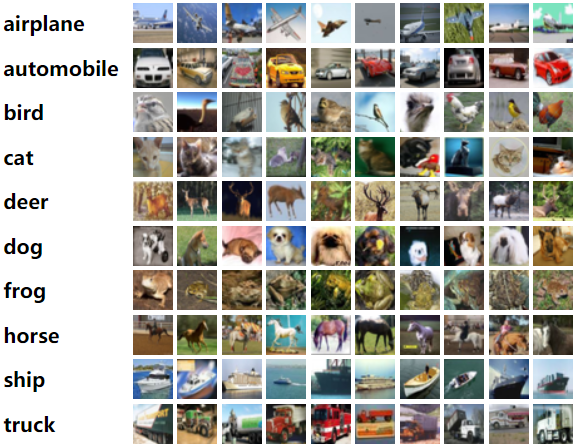

We will use the **ResNet-34** model, a deep convolutional neural network that incorporates **residual connections** to enable efficient training of deeper architectures.  

The model is available in `torchvision.models`, so there is no need to implement it from scratch! 😊

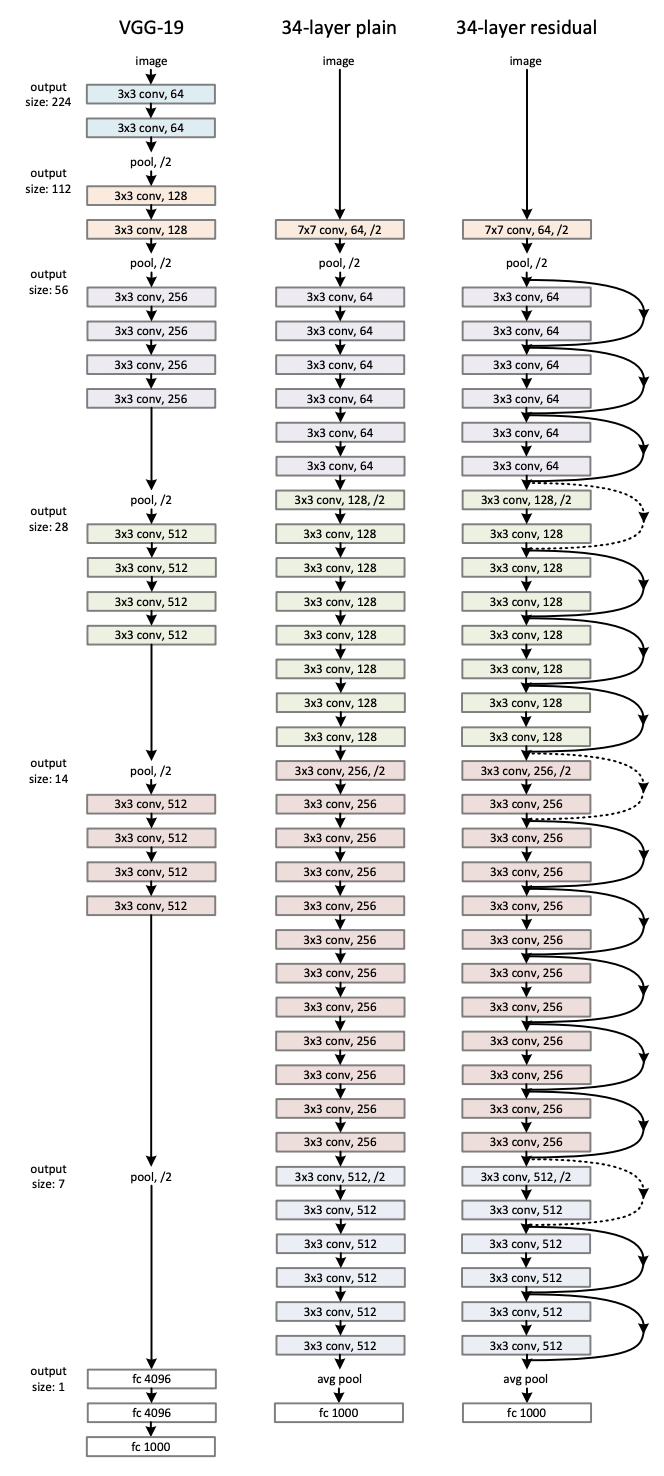

**Complete** the code below to train the model. Note: Training might take about 10-15 minutes. Make sure you use the GPU.

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter


def get_data_loaders(batch_size=64, num_workers=2):
    """Prepares data loaders for CIFAR-10 dataset.

    Args:
        batch_size (int): Batch size for data loading.
        num_workers (int): Number of workers for data loading.

    Returns:
        tuple: train_loader, val_loader, and test_loader (DataLoader objects).
    """
    # Data transformations (resize, normalize)
    transform = transforms.Compose([
        transforms.Resize(224),  # Resizing image to 224x224 for ResNet input
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize image with mean=0.5, std=0.5
    ])

    # Load CIFAR-10 dataset
    full_train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

    # Split dataset into training and validation sets (80/20 split)
    train_size = int(0.8 * len(full_train_dataset))
    val_size = len(full_train_dataset) - train_size
    train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

    # Load the test dataset
    test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

    # DataLoader for train, validation, and test datasets
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

    return train_loader, val_loader, test_loader

def build_model():
    """Builds the ResNet-34 model for CIFAR-10 classification.

    Returns:
        model: The ResNet-34 model with modified fully connected layer.
    """
    model = models.resnet34(weights=None)
    num_ftrs = model.fc.in_features  # Get the number of features in the last fully connected layer
    model.fc = nn.Linear(num_ftrs, 10)  # Modify the fully connected layer for CIFAR-10 (10 classes)
    model = model.to(device)  # Move model to device (GPU or CPU)
    return model

def get_optimizer_and_loss(model, lr=0.001):
    """Returns the optimizer and loss function for training.

    Args:
        model: The neural network model.
        lr (float): Learning rate for the optimizer.

    Returns:
        tuple: The loss function (CrossEntropyLoss), and optimizer (Adam)
    """
    criterion = nn.CrossEntropyLoss()
    # Loss function for classification # Your code Here. Aim for 1 line.
    optimizer = optim.Adam(model.parameters(), lr=lr)
    # Adam optimizer # Your code Here. Aim for 1 line.
    return criterion, optimizer

def compute_loss(model, data, target, criterion):
    """Computes the loss.

    Args:
        model: The neural network model.
        data: The input data (images).
        target: The ground truth labels.
        criterion: The loss function.

    Returns:
        tuple: Model output and loss value.
    """
    output = model(data)  # Forward pass # Your code Here. Aim for 1 line.
    loss = criterion(output, target)  # Compute loss # Your code Here. Aim for 1 line.
    return output, loss

def evaluate(loader, model, criterion, epoch, mode="Validation"):
    """Evaluates the model on the given dataset (train, val, or test).

    Args:
        loader: DataLoader object for the dataset.
        model: The trained model.
        criterion: The loss function.
        epoch: The current epoch number.
        mode (str): Mode of evaluation (e.g., "Validation", "Test").

    Returns:
        tuple: Average loss and accuracy for the dataset.
    """
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    total_loss = 0.0

    with torch.no_grad():  # Disable gradient computation for evaluation
        for data, target in loader:
            data, target = data.to(device), target.to(device)  # Move data to device
            output, loss = compute_loss(model, data, target, criterion)  # Compute output and loss

            total_loss += loss.item()  # Accumulate loss
            _, predicted = torch.max(output, 1)  # Get the predicted class
            total += target.size(0)  # Number of samples
            correct += (predicted == target).sum().item()  # Count correct predictions

    # Compute average loss and accuracy
    avg_loss = total_loss / len(loader)
    accuracy = correct / total
    return avg_loss, accuracy

def run_optimizer(optimizer, loss):
    """Performs and optimizer step.

    Args:
        optimizer: The optimizer for training.
        loss: The loss value.
    """
    optimizer.zero_grad()  # Clear gradients
    loss.backward()  # Compute gradients
    optimizer.step()  # Update weights
    # Your code Here. Aim for 3 lines.

def train_epoch(model, train_loader, criterion, optimizer, epoch):
    """Performs training for a single epoch.

    Args:
        model: The neural network model.
        train_loader: DataLoader for the training dataset.
        criterion: The loss function.
        optimizer: The optimizer for training.
        epoch (int): Current epoch number.

    Returns:
        tuple: Average training loss and average batch time.
    """
    model.train()  # Set the model to training mode
    epoch_loss = 0.0
    batch_times = []

    for batch_idx, (data, target) in enumerate(train_loader):
        start_time = time.time()  # Track batch processing time
        data, target = data.to(device), target.to(device)  # Move data to device
        output, loss = compute_loss(model, data, target, criterion)  # Compute loss
        run_optimizer(optimizer, loss)  # Update weights based on loss
        epoch_loss += loss.item()  # Accumulate loss
        batch_times.append(time.time() - start_time)  # Track batch time

    avg_train_loss = epoch_loss / len(train_loader)  # Compute average loss for the epoch
    avg_batch_time = sum(batch_times) / len(batch_times)  # Compute average batch time

    return avg_train_loss, avg_batch_time

def train_model(num_epochs=3, batch_size=128, lr=0.001):
    """Main function to train the ResNet-34 model.

    Args:
        num_epochs (int): Number of epochs for training.
        batch_size (int): Batch size for data loading.
        lr (float): Learning rate for the optimizer.

    Returns:
        model: The trained ResNet-34 model.
    """
    # Check for CUDA availability, and set device accordingly
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train_loader, val_loader, test_loader = get_data_loaders(batch_size)  # Get data loaders
    model = build_model()  # Build the model
    criterion, optimizer = get_optimizer_and_loss(model, lr)  # Get optimizer and loss function

    for epoch in range(num_epochs):
        avg_train_loss, avg_batch_time = train_epoch(model, train_loader, criterion, optimizer, epoch)

        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_train_loss:.4f}, Avg Batch Time: {avg_batch_time:.4f}s")

        # Evaluate on validation set
        val_loss, val_acc = evaluate(val_loader, model, criterion, epoch, mode="Validation")

        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

    # Final evaluation on test set
    test_loss, test_acc = evaluate(test_loader, model, criterion, num_epochs, mode="Test")
    print(f"Final Test Accuracy: {test_acc:.4f}")

    return model  # Return the trained model


# Run the training process
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = train_model()

100%|██████████| 170M/170M [00:13<00:00, 13.1MB/s]


Epoch 1/3, Loss: 1.5218, Avg Batch Time: 0.6447s
Validation Loss: 1.3844, Validation Accuracy: 0.5014
Epoch 2/3, Loss: 0.9962, Avg Batch Time: 0.6504s
Validation Loss: 0.9970, Validation Accuracy: 0.6511
Epoch 3/3, Loss: 0.7649, Avg Batch Time: 0.6506s
Validation Loss: 0.7748, Validation Accuracy: 0.7354
Final Test Accuracy: 0.7332


If everything runs smoothly, you should see results similar to the following:  

```
Epoch 1/3, Loss: 1.5910, Avg Batch Time: 0.6425s  
Validation Loss: 1.3784, Validation Accuracy: 0.5026  
Epoch 2/3, Loss: 1.0756, Avg Batch Time: 0.6421s  
Validation Loss: 0.9655, Validation Accuracy: 0.6561  
Epoch 3/3, Loss: 0.8040, Avg Batch Time: 0.6421s  
Validation Loss: 0.8616, Validation Accuracy: 0.6924  
Final Test Accuracy: 0.7013  
```

While running more epochs could improve performance, we limit it in this lab to keep the computational cost manageable.

## Exercise 1.2 — Transfer Learning  

In the previous exercise, the model was **randomly initialized**, meaning it started learning from scratch. A more effective approach is to **initialize the model with pre-trained parameters** from a related task, such as **object classification on ImageNet**.  

This technique, known as **Transfer Learning**, allows the model to leverage knowledge from a large dataset, leading to **faster convergence** and **better performance**, especially when working with smaller datasets like CIFAR-10.

Let's try to do that. Please, read the Pytorch documentation on the [ResNet34](https://pytorch.org/vision/main/models/generated/torchvision.models.resnet34.html) to figure out how we can do pretraining (note that the "DEFAULT" option is fine).

**Complete** the code below enable model pretraining.

In [8]:
def build_model():
    """Builds the ResNet-34 model for CIFAR-10 classification.

    Returns:
        model: The ResNet-34 model with modified fully connected layer.
    """
    model = models.resnet34(weights="DEFAULT")
    # Your code here. Aim for 1 line.
    num_ftrs = model.fc.in_features  # Get the number of features in the last fully connected layer
    model.fc = nn.Linear(num_ftrs, 10)  # Modify the fully connected layer for CIFAR-10 (10 classes)
    model = model.to(device)  # Move model to device (GPU or CPU)
    return model


In [9]:
# Run the training process
model = train_model()

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 187MB/s]


Epoch 1/3, Loss: 0.5536, Avg Batch Time: 0.6473s
Validation Loss: 0.5041, Validation Accuracy: 0.8291
Epoch 2/3, Loss: 0.3158, Avg Batch Time: 0.6435s
Validation Loss: 0.3807, Validation Accuracy: 0.8735
Epoch 3/3, Loss: 0.2185, Avg Batch Time: 0.6437s
Validation Loss: 0.3881, Validation Accuracy: 0.8789
Final Test Accuracy: 0.8752


If everthing goes well, you should observe a output similar to this one:

```
Epoch 1/3, Loss: 0.5743, Avg Batch Time: 0.6359s
Validation Loss: 0.4876, Validation Accuracy: 0.8403
Epoch 2/3, Loss: 0.3139, Avg Batch Time: 0.6333s
Validation Loss: 0.3757, Validation Accuracy: 0.8744
Epoch 3/3, Loss: 0.2214, Avg Batch Time: 0.6316s
Validation Loss: 0.3215, Validation Accuracy: 0.8953
Final Test Accuracy: 0.8930
```

As expected, we can see a **significant improvement in performance**, with accuracy increasing from aound **70%** to more than **85%**.

## Exercise 1.3 — Automatic Mixed Precision (AMP)  

You may have noticed that the training process is **quite slow**. This is expected since **ResNet-34** is a relatively large model with **34 residual blocks**. However, we can **speed up training** by using **Automatic Mixed Precision (AMP)**.  

AMP is a technique that **dynamically adjusts** the precision of calculations (switching between **float32** and **float16**) to **reduce memory usage** and **increase computation speed**, while (most of the times) maintaining model accuracy.  

You can learn more about how AMP is implemented in PyTorch **[here](https://pytorch.org/tutorials/recipes/recipes/amp_recipe.html)**.

**Complete** the code below to implement AMP.

In [16]:
import torch
import torch.amp as amp

def run_optimizer(optimizer, loss, scaler):
    """Performs optimizer step with gradient scaling.

    Args:
        optimizer: The optimizer for training.
        loss: The loss value.
        scaler: The gradient scaler for AMP.
    """
    # Your code here. Aim for 4 lines.
    scaler.scale(loss).backward() # Your code here. Aim for 4 lines.
    scaler.step(optimizer)
    scaler.update()
    optimizer.zero_grad()

def compute_loss(model, data, target, criterion):
    """Computes the loss with Automatic Mixed Precision (AMP).

    Args:
        model: The neural network model.
        data: The input data (images).
        target: The ground truth labels.
        criterion: The loss function.

    Returns:
        tuple: Model output and loss value.
    """
    # Your code here. Aim for 3 lines.
    with amp.autocast(device_type='cuda', dtype=torch.float16): # Your code here. Aim for 3 lines.
        output = model(data)
        loss = criterion(output, target)
    return output, loss


def train_epoch(model, train_loader, criterion, optimizer, epoch, scaler):
    """Performs training for a single epoch.

    Args:
        model: The neural network model.
        train_loader: DataLoader for the training dataset.
        criterion: The loss function.
        optimizer: The optimizer for training.
        epoch (int): Current epoch number.
        scaler: The gradient scaler for AMP.

    Returns:
        tuple: Average training loss and average batch time.
    """
    model.train()  # Set the model to training mode
    epoch_loss = 0.0
    batch_times = []

    for batch_idx, (data, target) in enumerate(train_loader):
        start_time = time.time()  # Track batch processing time
        data, target = data.to(device), target.to(device)  # Move data to device
        output, loss = compute_loss(model, data, target, criterion)  # Compute loss
        run_optimizer(optimizer, loss, scaler)  # Update weights based on loss
        epoch_loss += loss.item()  # Accumulate loss
        batch_times.append(time.time() - start_time)  # Track batch time

    avg_train_loss = epoch_loss / len(train_loader)  # Compute average loss for the epoch
    avg_batch_time = sum(batch_times) / len(batch_times)  # Compute average batch time

    return avg_train_loss, avg_batch_time


def train_model(num_epochs=3, batch_size=128, lr=0.001):
    """Main function to train the ResNet-34 model.

    Args:
        num_epochs (int): Number of epochs for training.
        batch_size (int): Batch size for data loading.
        lr (float): Learning rate for the optimizer.

    Returns:
        model: The trained ResNet-34 model.
    """
    # Check for CUDA availability, and set device accordingly
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train_loader, val_loader, test_loader = get_data_loaders(batch_size)  # Get data loaders
    model = build_model()  # Build the model
    criterion, optimizer = get_optimizer_and_loss(model, lr)  # Get optimizer and loss function
    scaler = amp.GradScaler() # Initialize the scalar # Your code here. Aim for 1 line.

    for epoch in range(num_epochs):
        avg_train_loss, avg_batch_time = train_epoch(model, train_loader, criterion, optimizer, epoch, scaler)

        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_train_loss:.4f}, Avg Batch Time: {avg_batch_time:.4f}s")

        # Evaluate on validation set
        val_loss, val_acc = evaluate(val_loader, model, criterion, epoch, mode="Validation")

        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

    # Final evaluation on test set
    test_loss, test_acc = evaluate(test_loader, model, criterion, num_epochs, mode="Test")
    print(f"Final Test Accuracy: {test_acc:.4f}")

    return model  # Return the trained model

In [17]:
# Run the training process
model = train_model()

Epoch 1/3, Loss: 0.5500, Avg Batch Time: 0.2806s
Validation Loss: 0.5373, Validation Accuracy: 0.8203
Epoch 2/3, Loss: 0.3133, Avg Batch Time: 0.2786s
Validation Loss: 0.3408, Validation Accuracy: 0.8826
Epoch 3/3, Loss: 0.2151, Avg Batch Time: 0.2780s
Validation Loss: 0.3526, Validation Accuracy: 0.8846
Final Test Accuracy: 0.8828


If everything goes well, your results should look similar to the following:  

```
Epoch 1/3, Loss: 0.5777, Avg Batch Time: 0.2777s
Validation Loss: 0.4557, Validation Accuracy: 0.8456
Epoch 2/3, Loss: 0.3217, Avg Batch Time: 0.2761s
Validation Loss: 0.3984, Validation Accuracy: 0.8683
Epoch 3/3, Loss: 0.2278, Avg Batch Time: 0.2762s
Validation Loss: 0.3673, Validation Accuracy: 0.8841
Final Test Accuracy: 0.8786
```  

The **model performance remains similar**, but the **average batch time is drastically reduced**—from **0.60 sec/batch** to just **0.27 sec/batch**.

This is a **huge improvement** in training efficiency!



## Exercise 1.4 — Compilation  

As discussed in the lecture, **PyTorch supports model compilation** using `torch.compile`, which can **optimize model execution** for improved performance.  

You can check out the official **[documentation here](https://pytorch.org/docs/stable/generated/torch.compile.html)** and a **[tutorial here](https://pytorch.org/tutorials/intermediate/torch_compile_tutorial.html)**.  

Now, let's see if we can **further speed up** our model by applying compilation!


**Complete** the code below to compile the model.

In [18]:
import torchvision.models as models

def build_model():
    """Builds the ResNet-34 model for CIFAR-10 classification.

    Returns:
        model: The ResNet-34 model with modified fully connected layer.
    """
    model = models.resnet34(weights="DEFAULT") # Your Code here (use the same pretrained weights as before). Aim for 1 line.
    num_ftrs = model.fc.in_features  # Get the number of features in the last fully connected layer
    model.fc = nn.Linear(num_ftrs, 10)  # Modify the fully connected layer for CIFAR-10 (10 classes)
    model = model.to(device)  # Move model to device (GPU or CPU)
    model = torch.compile(model) # Compile the model for performance # Your Code here. Aim for 1 line.
    return model

In [20]:
# Run the training process
model = train_model()

Epoch 1/3, Loss: 0.5578, Avg Batch Time: 0.2555s
Validation Loss: 0.4684, Validation Accuracy: 0.8475
Epoch 2/3, Loss: 0.3150, Avg Batch Time: 0.2545s
Validation Loss: 0.3963, Validation Accuracy: 0.8673
Epoch 3/3, Loss: 0.2178, Avg Batch Time: 0.2535s
Validation Loss: 0.3325, Validation Accuracy: 0.8871
Final Test Accuracy: 0.8875


If everything goes well, you should observe something like this:

```
Epoch 1/3, Loss: 0.5589, Avg Batch Time: 0.6648s
Validation Loss: 0.4824, Validation Accuracy: 0.8393
Epoch 2/3, Loss: 0.3139, Avg Batch Time: 0.2534s
Validation Loss: 0.3610, Validation Accuracy: 0.8765
Epoch 3/3, Loss: 0.2225, Avg Batch Time: 0.2509s
Validation Loss: 0.3190, Validation Accuracy: 0.8938
Final Test Accuracy: 0.8920
```

You can notice that model performance remains similar, but after the first epoch, a speed-up occurs (e.g., the average batch time drops from 0.27 sec/batch to 0.25 sec/batch).


In the end, we were able to significantly improve performance while also making the code much more computationally efficient.

That's all!